存在缺失值的用户的标签:
5      0.0
56     0.0
91     0.0
404    0.0
434    0.0
Name: outcome, dtype: float64


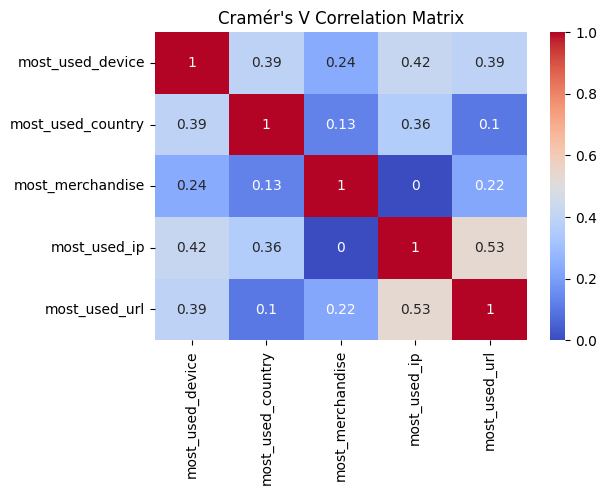

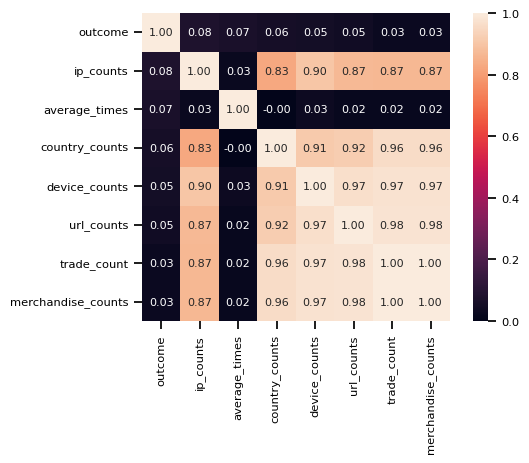

与标签 'outcome' 相关性最大的7个属性：
Index(['ip_counts', 'average_times', 'country_counts', 'device_counts',
       'url_counts', 'trade_count', 'merchandise_counts'],
      dtype='object')
最佳参数组合:  {'criterion': 'gini', 'max_features': 4, 'n_estimators': 100}
最佳准确率:  0.9523137254901961
调优后RF准确率： 0.9562352941176471


c:\Users\xiwei\miniconda3\envs\data_science\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\xiwei\miniconda3\envs\data_science\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\xiwei\miniconda3\envs\data_science\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\xiwei\miniconda3\envs\data_science\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

最佳参数组合： {'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.1, 'n_estimators': 200}
最佳准确率： 0.9603137254901959
调优后AB准确率： 0.9603137254901959
最佳参数组合： {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
最佳准确率： 0.9522352941176472
调优后Bagging准确率： 0.9482352941176471


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- most_used_country_ae
- most_used_country_ar
- most_used_country_au
- most_used_country_az
- most_used_country_ba
- ...


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # 决策树
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

# 读取数据
trade_df = pd.read_csv('./trade.csv')
train_df = pd.read_csv('./user_train.csv')
test_df = pd.read_csv('./user_test.csv')

# 使用 Z-score 标准化
z_score_scaler = StandardScaler()
trade_df['time_normalized'] = z_score_scaler.fit_transform(trade_df[['time']])

def trade_data_processing(trade_df):
    trade_count = trade_df.groupby('bidder_id').size().reset_index(name='trade_count')
    device_counts = trade_df.groupby(['bidder_id', 'device']).size().reset_index(name='device_counts')
    most_used_devices = device_counts.loc[device_counts.groupby('bidder_id')['device_counts'].idxmax()]
    most_used_devices = most_used_devices.rename(columns={"device": "most_used_device"}).reset_index(drop=True)

    country_counts = trade_df.groupby(['bidder_id', 'country']).size().reset_index(name='country_counts')
    most_used_countries = country_counts.loc[country_counts.groupby('bidder_id')['country_counts'].idxmax()]
    most_used_countries = most_used_countries.rename(columns={"country": "most_used_country"}).reset_index(drop=True)

    merchandise_counts = trade_df.groupby(['bidder_id', 'merchandise']).size().reset_index(name='merchandise_counts')
    most_merchandise = merchandise_counts.loc[merchandise_counts.groupby('bidder_id')['merchandise_counts'].idxmax()]
    most_merchandise = most_merchandise.rename(columns={"merchandise": "most_merchandise"}).reset_index(drop=True)

    ip_counts = trade_df.groupby(['bidder_id', 'ip']).size().reset_index(name='ip_counts')
    most_used_ip = ip_counts.loc[ip_counts.groupby('bidder_id')['ip_counts'].idxmax()]
    most_used_ip = most_used_ip.rename(columns={"ip": "most_used_ip"}).reset_index(drop=True)

    url_counts = trade_df.groupby(['bidder_id', 'url']).size().reset_index(name='url_counts')
    most_used_url = url_counts.loc[url_counts.groupby('bidder_id')['url_counts'].idxmax()]
    most_used_url = most_used_url.rename(columns={"url": "most_used_url"}).reset_index(drop=True)

    average_times = trade_df.groupby('bidder_id')['time_normalized'].mean().reset_index(name='average_times')

    feature_df = trade_count.merge(most_used_devices, on='bidder_id', how='left')
    feature_df = feature_df.merge(most_used_countries, on='bidder_id', how='left')
    feature_df = feature_df.merge(average_times, on='bidder_id', how='left')
    feature_df = feature_df.merge(most_merchandise, on='bidder_id', how='left')
    feature_df = feature_df.merge(most_used_ip, on='bidder_id', how='left')
    feature_df = feature_df.merge(most_used_url, on='bidder_id', how='left')

    return feature_df

# 处理 trade_df
user_feature_df = trade_data_processing(trade_df)

# 合并特征到训练和测试数据集
train_df = train_df.merge(user_feature_df, on='bidder_id', how='left')
test_df = test_df.merge(user_feature_df, on='bidder_id', how='left')

# 查看train_df每一列的缺失值,推测缺失值是没有进行交易的用户
missing_values_per_column = train_df.isnull().sum()
missing_values_per_column

# 查看test_df每一列的缺失值,推测缺失值是没有进行交易的用户
missing_values_per_column2 = test_df.isnull().sum()
missing_values_per_column2
missing_mask = test_df.isnull().any(axis=1)

# 查找包含缺失值的行并输出标签
def print_missing_labels(df, label_col):
    missing_rows = df[df.isnull().any(axis=1)]
    if not missing_rows.empty:
        print("存在缺失值的用户的标签:")
        print(missing_rows[label_col])
    else:
        print("没有缺失值.")

# 打印训练数据集中包含缺失值的行的标签
print_missing_labels(train_df, 'outcome')

def fillNAN(df):
    # 选择数值型和布尔型数据
    num_columns = df.select_dtypes(include=["number", "bool"]).columns
    # 选择标称属性（非数值型和布尔型数据）
    cat_columns = df.select_dtypes(exclude=["number", "bool"]).columns

    # 填充数值型和布尔型数据的缺失值为平均数
    for col in num_columns:
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)

    # 填充标称属性的缺失值为众数
    for col in cat_columns:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)

    # 查看填充后的数据集
    return df
# 填充缺失值
train_df = fillNAN(train_df)
test_df = fillNAN(test_df)

def remove_outliers_box(df):
    cleaned_df = df.copy()  

    # 处理连续型特征
    #continuous_features = df.drop(columns=['outcome']).select_dtypes(include=['number']).columns
    连续型特征 = df.drop(columns=['outcome']).select_dtypes(include=['number']).columns
    for column in 连续型特征:
        # 使用箱线图计算上下边缘
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr

        # 去除异常值
        df[column] = np.where(df[column] > upper, upper, df[column])
        df[column] = np.where(df[column] < lower, lower, df[column])

    # 处理标称特征（如果需要的话）

    return cleaned_df
# 去除异常值
train_df = remove_outliers_box(train_df)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
categorical_columns = ['most_used_device', 'most_used_country', 'most_merchandise','most_used_ip','most_used_url']

# 计算Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()  # 修改这里
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# 创建一个存储相关系数矩阵的DataFrame
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                                index=categorical_columns, columns=categorical_columns)

# 计算所有标称属性之间的Cramér's V值
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(train_df[col1], train_df[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# 绘制相关系数矩阵的热图
plt.figure(figsize=(6, 4))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
# 选择数值型和布尔型数据
num_features = train_df.select_dtypes(include=["number", "bool"]).copy()
num_features = num_features.apply(lambda x: int(x) if isinstance(x, bool) else x)
# 计算相关系数矩阵
corrmat = num_features.corr()

# 选择与目标变量 'outcome' 相关性最大的5个属性
k = 8
cols = corrmat.nlargest(k + 1, 'outcome')['outcome'].index  # 加1是因为包括了目标变量本身
cm = np.corrcoef(train_df[cols].values.T)

# 画出heatmap
sns.set_context("notebook", font_scale=0.75)
plt.figure(figsize=(6, 4))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

print("与标签 'outcome' 相关性最大的7个属性：")
print(cols[1:])


def generate_feature_interactions_and_encode(train_df, test_df, categorical_features):
    # 生成特征交互
    for feature1 in categorical_features:
        for feature2 in categorical_features:
            if feature1 != feature2:
                train_df[f'{feature1}-{feature2}'] = train_df[feature1].astype(str) + '-' + train_df[feature2].astype(str)
                test_df[f'{feature1}-{feature2}'] = test_df[feature1].astype(str) + '-' + test_df[feature2].astype(str)

    # 合并训练集和测试集
    combined_df = pd.concat([train_df, test_df], keys=['train', 'test'])

    # 独热编码
    interaction_features = [f'{feature1}-{feature2}' for feature1 in categorical_features for feature2 in categorical_features if feature1 != feature2]
    combined_encoded = pd.get_dummies(combined_df, columns=categorical_features + interaction_features)

    # 拆分回训练集和测试集
    train_encoded = combined_encoded.xs('train')
    test_encoded = combined_encoded.xs('test')

    return train_encoded, test_encoded
'''
'most_used_ip', 'most_used_device'
'most_used_ip', 'most_used_url'

'''
categorical_features = ['most_used_ip', 'most_used_device']
train_encoded, test_encoded = generate_feature_interactions_and_encode(train_df, test_df, categorical_features)

# 合并训练集和测试集
combined_df = pd.concat([train_encoded, test_encoded], keys=['train', 'test'])
# 进行独热编码
# 'most_used_device', 'most_used_ip','most_used_country','most_merchandise','most_used_url'
categorical_features = ['most_used_country']
combined_encoded = pd.get_dummies(combined_df, columns=categorical_features)

# 拆分回训练集和测试集
train_encoded = combined_encoded.xs('train')
test_encoded = combined_encoded.xs('test')

# 转换布尔型数据为数值型
for column in train_df.columns:
    if train_df[column].dtype == bool:
        train_df[column] = train_df[column].astype(np.float64)
for column in test_df.columns:
    if test_df[column].dtype == bool:
        test_df[column] = test_df[column].astype(np.float64)

#删去非数值属性的列用于训练
columns1 = train_encoded.select_dtypes(exclude=["number", "bool"]).columns
number_train = train_encoded.drop(columns=columns1)
number_test = test_encoded.drop(columns=columns1)
number_test = number_test.drop(columns=['outcome'])

# Y1 = number_train['outcome']
# X1 = number_train.drop(columns=['outcome']).select_dtypes(include=['number'])

# 将number_train划分为数据集和训练集来训练模型
train_df_train, train_df_test = train_test_split(number_train, test_size=0.5, random_state=42)
Y = train_df_train['outcome']
X = train_df_train.drop(columns=['outcome']).select_dtypes(include=['number'])

# 定义要调优的参数网格
param_grid1 = {
    'n_estimators': [50, 100, 150],
    'max_features': [2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# 创建随机森林分类器
clf1 = RandomForestClassifier(n_estimators=50,max_features=2,criterion='gini')

# 实例化 GridSearchCV 对象
grid_search1 = GridSearchCV(clf1, param_grid1, cv=5)

# 使用网格搜索对模型进行参数调优
grid_search1.fit(X, Y)

# 输出最佳参数组合和对应的评分
print("最佳参数组合: ", grid_search1.best_params_)
print("最佳准确率: ", grid_search1.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf1 = grid_search1.best_estimator_
scores = cross_val_score(best_clf1, X, Y, cv=5)
print('调优后RF准确率：', scores.mean())


# 定义要调优的参数范围
param_grid2 = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
    'algorithm': ['SAMME', 'SAMME.R']
}
clf2 = AdaBoostClassifier()


# 使用网格搜索进行参数调优
grid_search2 = GridSearchCV(estimator=clf2, param_grid=param_grid2, cv=5, scoring='accuracy')
grid_search2.fit(X, Y)

# 打印最佳参数组合
print("最佳参数组合：", grid_search2.best_params_)
print("最佳准确率：", grid_search2.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf2 = grid_search2.best_estimator_
scores = cross_val_score(best_clf2, X, Y, cv=5)
print('调优后AB准确率：', scores.mean())

from sklearn.metrics import accuracy_score
# 初始化模型
estimator = KNeighborsClassifier()
clf3 = BaggingClassifier(estimator=estimator)

# 定义参数网格
param_grid3 = {
    'n_estimators': [10, 20, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# 使用 GridSearchCV 进行参数调优
grid_search3 = GridSearchCV(estimator=clf3, param_grid=param_grid3, cv=5, scoring='accuracy', n_jobs=-1)
grid_search3.fit(X, Y)
# 打印最佳参数组合
print("最佳参数组合：", grid_search3.best_params_)
print("最佳准确率：", grid_search3.best_score_)

# 使用最佳参数训练模型并进行评估
best_clf3 = grid_search3.best_estimator_
scores = cross_val_score(best_clf3, X, Y, cv=5)
print('调优后Bagging准确率：', scores.mean())


y_real = train_df_test['outcome']
X_test = train_df_test.drop(columns=['outcome']).select_dtypes(include=["number", "bool"])
#selected_features

# 预测结果
y_pred1 = best_clf1.predict_proba(X_test)[:, 1]
y_pred2 = best_clf2.predict_proba(X_test)[:, 1]
y_pred3 = best_clf3.predict_proba(X_test)[:, 1]

# 计算AUC
auc1 = roc_auc_score(y_real, y_pred1)
print("Valid aUC1: ", auc1)
auc2 = roc_auc_score(y_real, y_pred2)
print("Valid aUC2: ", auc2)
auc3 = roc_auc_score(y_real, y_pred3)
print("Valid aUC3: ", auc3)

Y = number_train['outcome']
X = number_train.drop(columns=['outcome']).select_dtypes(include=['number'])

# 预测test_df数据集
X_test = number_test.select_dtypes(include=["number", "bool"])
y_test = best_clf1.predict_proba(X_test)[:, 1]
# 保留一位小数
y_test_rounded = np.round(y_test, 1)
# 保存预测结果
test_df['prediction'] = y_test
missing_predictions = test_df[missing_mask]
print(missing_predictions['prediction'])


test_df[['prediction']].to_csv('result.csv', index=False, header=False)

